# YouTube Comment Analysis

We will analyse YouTube video comments using various methods:

- investigate the donations for a video
- sentiment analysis using `TextBlob` and `VaderSentiment`
- estimation of the dislikes on a video based on the comment polarity and the likes
- extract the relevant terms of highly positive and negative comments using TF-IDF

Preparatory steps:

1. open a YouTube video in the Browser
2. inspect the page
3. copy the HTML `body` element
4. paste the element to `html_body.txt`

Note: if there are numerous comments on a video, it is recommended to scroll down a couple of times to get a representative overview of the comments before extracting the HTML.

## General Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import re
import seaborn as sns

from bs4 import BeautifulSoup
from googletrans import Translator
from matplotlib import pyplot as plt

In [ ]:
from src.methods import get_currency_conversion_df, concatenate_comments, get_comment_polarity_df, extract_relevant_terms, generate_wordcloud

## Parse HTML using BeautifulSoup

In [4]:
with open('./html_body.txt', 'r', encoding='utf-8') as file:
    raw_html = file.read()

In [5]:
soup = BeautifulSoup(raw_html)

## Donations

Let's analyse the donations on a video.

### Donation scraping

Scrape donations from the parsed HTML via the `comment-chip-price` spans.

In [6]:
price_spans = soup.findAll('span', {'id': 'comment-chip-price'})

In [7]:
donations = [elem.text.strip() for elem in price_spans if len(elem.text.strip()) > 0]

In [8]:
donation_df = pd.DataFrame([elem.split("\xa0") for elem in donations], 
                           columns=['donation', 'currency'])

In [9]:
donation_df.dtypes

donation    object
currency    object
dtype: object

In [10]:
donation_df['donation'] = donation_df['donation'].apply(lambda donation: donation.replace(',', '.')).astype(float)

### Currency conversion

Donation currencies may vary; we need to convert them to a single currency.

In [11]:
unique_currencies = donation_df['currency'].unique()

In [12]:
target_currency = 'USD'

In [13]:
curr_conv_df = get_currency_conversion_df(unique_currencies=unique_currencies,
                                          target_currency=target_currency)

In [14]:
merge = donation_df.merge(curr_conv_df, left_on='currency', right_on='currency', how='left')

### Summary of Donations

In [15]:
merge['conv_donation'] = merge['donation'] * merge['factor']

In [16]:
print(f"Total sum of donations: {merge['conv_donation'].sum():.2f} {target_currency}")

Total sum of donations: 1826.49 USD


In [17]:
sns.set(font_scale=1.3)

Text(0.5, 1.0, 'Donations')

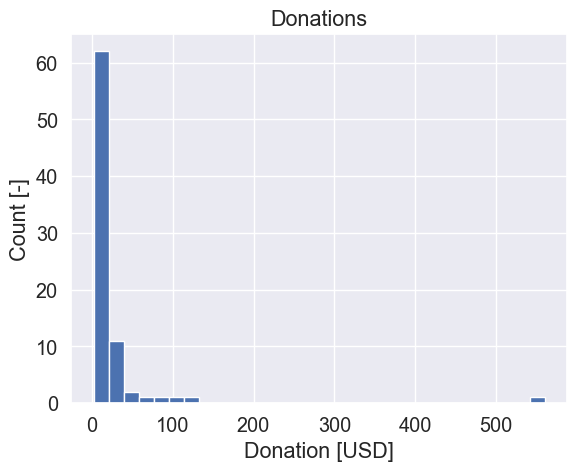

In [18]:
merge['conv_donation'].hist(bins=30)
plt.xlabel(f'Donation [{target_currency}]')
plt.ylabel('Count [-]')
plt.title('Donations')

## Sentiment Analysis

Depending on the scraped comments, sentiment extraction may require German corpora and the `textblob-de` package.

Here, we use `googletrans` to directly translate the comments to english (if required) and then perform sentiment analysis on these translations using `textblob`.

### Comment Extraction

In [19]:
content_divs = soup.find('div', {'id': 'contents', 
                                 'class': 'style-scope ytd-item-section-renderer style-scope ytd-item-section-renderer'})

In [20]:
comment_spans = content_divs.findAll('span', {'role': 'text'})

In [21]:
comments = [comment.text.strip() for comment in comment_spans if 'Antwort' not in comment.text.strip()]

In [ ]:
comments[:5]

In [23]:
len(comments)

225

### Comment Translation

In [24]:
translator = Translator()

#### Test translation

In [ ]:
translator.translate(comments[0], dest='en').text

#### Concatenation of Comments, Translation, and Split

The Google API has rate limits; we concatenate the data into chunks of up to 3000 characters and then translate each chunk in one go, followed by splitting into individual comments.

In [26]:
separator: str = " ||| "

In [27]:
concatenates = concatenate_comments(comments=comments,
                                    separator=separator)

#### Translation via Google Translate

In [28]:
from tqdm import tqdm

In [29]:
raw_translations = []
failed = []
for i, concatenate in tqdm(
    enumerate(concatenates), 
    total=len(concatenates), 
    desc='Translating comment concatenates'
):
    try:
        raw_translations.append(translator.translate(concatenate, dest='en'))
    except Exception as e:
        print(f"Error translating chunk {i}: {type(e)}: {e}")
        failed.append(concatenate)

Translating comment concatenates: 100%|████████████████████████████████████████████████| 13/13 [00:03<00:00,  3.54it/s]


In [30]:
print(f"Translation of {len(failed)} chunks failed.")

Translation of 0 chunks failed.


In [31]:
combined_translations = separator.join([translation.text for translation in raw_translations])

In [32]:
translated_comments = combined_translations.split("|||")

In [33]:
len(comments)

225

In [34]:
len(translated_comments)

221

In [ ]:
translated_comments[:3]

### Sentiment Extraction

Based on the translated comments, we now extract sentiments via the `VaderSentiment` and `TextBlob` packages.

Conceptual difference: VADER (Valence Aware Dictionary and sEntiment Reasoner) is designed specifically for social media sentiments (e.g., regarding processing of emoticons and exclamatory expressions), whereas TextBlob is a general purpose tool. VADER classifies the text in proportions of negative and positive elements and a compound score, whereas TextBlob only provides a polarity score and an estimate of subjectivity. Both approaches are lexicon-based, but TextBlob additionally incorporates an NaiveBayes classifier.

In [36]:
comment_df = get_comment_polarity_df(comments=translated_comments)

In [ ]:
comment_df

#### Isolation of problematic cases

To investigate the feasibility of our analysis, we check for internal consistency by counting the cases where both polarity analyses diverge strongly.

We will do so in two ways:

1. extraction of cases where one analysis yielded a positive and one analysis yielded a negative polarity
2. extraction of cases where the extracted polarities differ by 0.5

In [38]:
positive_vs_negative_comments = comment_df.query(
    '(polarity_textblob > 0.2 & polarity_vader < -0.2) | (polarity_textblob < -0.2 & polarity_vader > 0.2)'
)

In [ ]:
positive_vs_negative_comments

In [40]:
print(f"{len(positive_vs_negative_comments)} cases ({len(positive_vs_negative_comments)/len(comment_df):.1%}) where analyses yielded opposite sentiment.")

2 cases (0.9%) where analyses yielded opposite sentiment.


In [41]:
absolute_polarity_divergence_comments = comment_df.query(
    '(polarity_textblob - polarity_vader < -0.5) | (polarity_textblob - polarity_vader > 0.5)'
)

In [ ]:
absolute_polarity_divergence_comments

In [43]:
print(f"{len(absolute_polarity_divergence_comments)} cases ({len(absolute_polarity_divergence_comments)/len(comment_df):.1%}) where analyses yielded a delta of 0.5 for the polarity.")

72 cases (32.6%) where analyses yielded a delta of 0.5 for the polarity.


#### Sentiment Visualisation

In [44]:
sns.set()

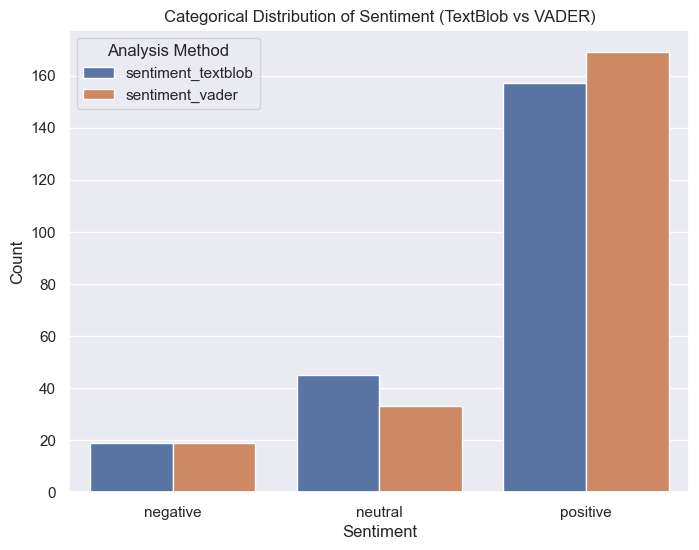

In [45]:
# melt the DF so we can plot both columns as categorical variables in the same plot
df_melted = comment_df.melt(value_vars=['sentiment_textblob', 'sentiment_vader'], 
                            var_name='Analysis Method', 
                            value_name='sentiment')

# plot using matplotlib / seaborn
plt.figure(figsize=(8, 6))
order = sorted(df_melted['sentiment'].unique())

sns.countplot(x='sentiment', 
              hue='Analysis Method',
              order=order,
              data=df_melted, 
              dodge=True)

plt.title('Categorical Distribution of Sentiment (TextBlob vs VADER)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [ ]:
comment_df.head()

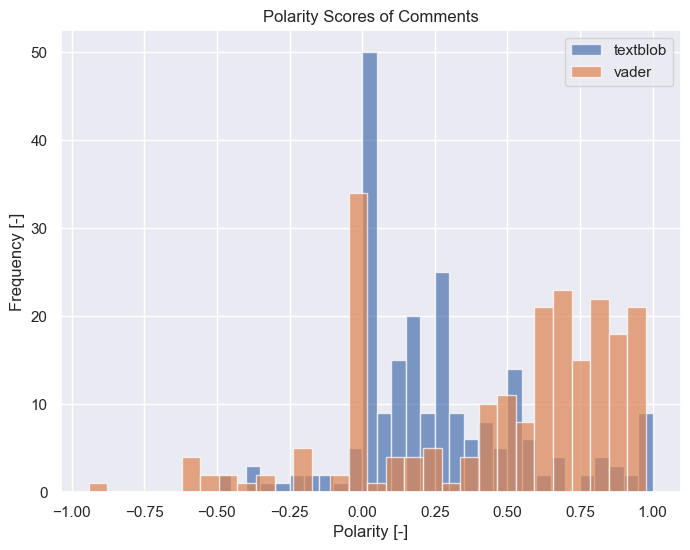

In [47]:
fig, ax = plt.subplots(figsize=(8, 6))
comment_df['polarity_textblob'].hist(bins=30, ax=ax, label='textblob', alpha=0.7)
comment_df['polarity_vader'].hist(bins=30, ax=ax, label='vader', alpha=0.7)
plt.title('Polarity Scores of Comments')
plt.xlabel('Polarity [-]')
plt.ylabel('Frequency [-]')
plt.legend()
plt.show()

If shifted to the right, overall sentiment is positive, if shifted to left, negative, if Gaussian, neutral.

## Dislike Estimation

We estimate the number of dislikes on the video based on overall polarity of the comments, assuming that the ratio of positive to negative comments roughly corresponds to the number of likes to dislikes.

### Overall Comment Polarity Counts

We assume that only very positive and very negative comments based on the mean of VADER and TextBlob polarity result in a like or dislike.

Let's define an absolute polarity cut-off for this purpose.

In [48]:
polarity_cutoff = 0.5

Mean of the polarity scores from the two different analysis methods:

In [49]:
comment_df['polarity_mean'] = (comment_df['polarity_vader'] + comment_df['polarity_textblob'])/ 2

In [50]:
highly_positive_count = (comment_df['polarity_mean'] > polarity_cutoff).astype(int).sum()

In [51]:
highly_negative_count = (comment_df['polarity_mean'] < -polarity_cutoff).astype(int).sum()

In [52]:
comment_ratio = highly_positive_count / highly_negative_count

In [53]:
print(f"Highly positive comments: {highly_positive_count}, highly negative comments: {highly_negative_count}, ratio positive/negative: {comment_ratio}")

Highly positive comments: 82, highly negative comments: 2, ratio positive/negative: 41.0


### Like Count

In [54]:
like_divs = soup.findAll('div', {'class': 'yt-spec-button-shape-next__button-text-content'})

In [55]:
like_divs = [int(div.text.replace('.', '')) for div in like_divs if re.match('^\d{1,3}(\.\d{3})*$',  # regex expression for multi-digit number with point
                                                                             div.text)]

In [56]:
like_count = like_divs[0]

In [57]:
like_count

314865

### Dislike Estimate

We will now estimate the dislikes based on the highly positive to negative comment ratio and the like count.

In [58]:
print(f"Likes: {like_count}")

Likes: 314865


In [59]:
print(f"Estimate of dislikes based on likes and comment polarity: {int(like_count / comment_ratio)}")

Estimate of dislikes based on likes and comment polarity: 7679


## Isolation of extreme polarity-related terms

We isolate relevant terms (in this case, adjectives) from the comments to see what is being critisized.

Method: Tf-Idf based on tokenized corpus. We'll work with the VADER polarity here as it is more suitable for social media content.

Tf-Idf works by extracting overall word counts (term frequency, TF) and isolating words that are common to just a fraction of the documents (inverse document frequency, IDF).

For preparation, we need to download stopwords and apply removal of them.

In [ ]:
results = extract_relevant_terms(comment_df)

print("Top positive terms:\n")
print(results['positive'])

print("\nTop negative terms:\n")
print(results['negative'])

#### Visualisation of relevant terms

Relevant terms can be visualised in a WordCloud. We'll use a custom color function to improve readibility.

In [ ]:
generate_wordcloud(results['positive'].head(10),
                   title='Positive Comments')

In [ ]:
generate_wordcloud(results['negative'].head(10),
                   title='Negative Comments')